# Problem statement :
To identify which customers are likely to make a specific transaction in the future, regardless of the transaction amount.

In [1]:
# import libraries
# system 
import os
import warnings
warnings.filterwarnings('ignore')

# data manipulation
import pandas as pd
import numpy as np 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz #inorder to generate visualizations of complex structures such as decision trees


from sklearn.naive_bayes import GaussianNB

# preprocessing/ cross-validation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

from scipy.stats import randint as sp_randint
# RandomizedSearchCV selects a random subset of parameters, which can significantly reduce computation time.

# evaluation metrics
from sklearn.metrics import make_scorer, roc_auc_score, auc, precision_score, recall_score, classification_report, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve

# decompostion 
from sklearn.decomposition import PCA

In [2]:
# Load data
data = pd.read_csv("train.csv")

Basic checks

In [3]:
data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
data.shape

(200000, 202)

In [5]:
data.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [7]:
data.target.value_counts()

target
0    179902
1     20098
Name: count, dtype: int64

<Axes: xlabel='target'>

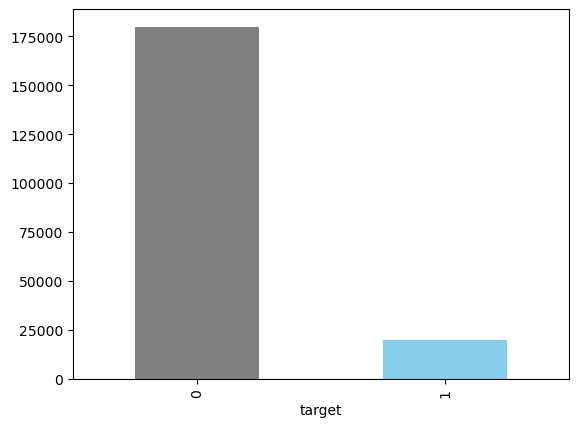

In [8]:
data["target"].value_counts().plot(kind='bar', color=["gray","skyblue"])

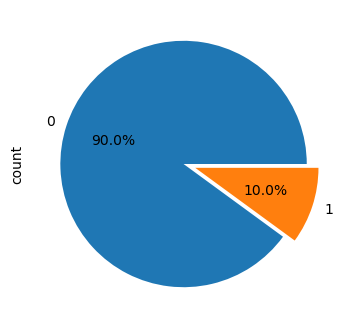

In [9]:
plt.figure(figsize=(6,4))
data['target'].value_counts().plot.pie(autopct='%1.1f%%', explode=([0,0.1]))
plt.show()

* Approximately 90% of the data belongs to class 0 and only 10% belongs to class 1
* Above shows that the data is not balanced
* The number of customers that will not make a transaction is much higher than those that will.

We divided the dataset into two parts one is dataset where the target value is 0 and other one is the dataset where the target value is 1

In [10]:
t0 = data.loc[data['target'] == 0] # t0 is the part of the dataset where the target value is 0.
t1 = data.loc[data['target'] == 1] # t1 is the part of the dataset where the target value is 1.

In [11]:
t0

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [12]:
t1

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
13,train_13,1,16.3699,1.5934,16.7395,7.3330,12.1450,5.9004,4.8222,20.9729,...,7.4002,7.4031,4.3989,4.0978,17.3638,-1.3022,9.6846,9.0419,15.6064,-10.8529
29,train_29,1,5.3301,-2.6064,13.1913,3.1193,6.6483,-6.5659,5.9064,15.2341,...,5.9215,7.9676,2.3405,1.1482,23.2168,-2.0105,3.7600,9.4513,17.4105,-14.6897
63,train_63,1,7.7072,0.0183,9.9974,8.3524,9.2886,-13.3627,6.0425,10.1108,...,1.5832,5.0039,3.8814,7.4241,21.4844,-0.8297,-3.0468,7.5790,15.7685,5.4769
65,train_65,1,10.5358,-2.5439,8.7394,6.7548,14.4099,-3.8724,5.1584,15.8381,...,4.6648,6.4227,3.4025,-4.0882,14.1174,-0.2472,5.3847,8.6949,15.1340,3.8449
71,train_71,1,6.7547,2.5973,14.2141,8.3514,7.4942,-1.3055,4.2336,15.0243,...,1.4677,3.5935,2.0013,1.5777,18.2820,-4.3408,6.8869,9.3567,18.9013,13.3447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199966,train_199966,1,13.5797,2.5526,6.0512,5.2730,12.2182,-3.4048,7.3623,17.8372,...,3.9023,7.9986,0.5213,2.3442,14.5510,-1.1530,8.9883,8.3389,9.5440,4.2493
199976,train_199976,1,7.9663,-2.8485,9.0919,7.3298,9.6690,-16.7872,4.5094,12.4351,...,10.7930,4.3876,3.7257,7.7038,14.7384,0.1561,1.5794,8.4627,14.3604,-1.6688
199981,train_199981,1,12.8140,0.6386,14.1657,7.1044,8.9365,-0.3274,6.5949,14.6078,...,4.8208,4.9010,2.2513,0.7308,14.7155,1.1464,5.5158,8.6519,16.0341,7.3809
199986,train_199986,1,12.0298,-8.7800,7.7071,7.4015,9.2305,-16.2174,5.9064,17.9268,...,16.7461,3.1249,-0.3943,8.4059,14.3367,3.0991,4.3853,8.8019,15.0031,-0.3659


In [13]:
print(t0.shape)
print(t1.shape)

(179902, 202)
(20098, 202)


In [14]:
print(t0.value_counts().sum()/len(data)*100 )
print(t1.value_counts().sum()/len(data)*100)

89.95100000000001
10.049


Out of the 200000 rows 90% come under the class 0 and 10% comes under the class 1

### Preprocessing

In [15]:
# Missing Values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("Columns with missing values:")
print(missing_data[missing_data['Missing Values'] > 0])

Columns with missing values:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


* Fortunately, there are no null values in any feature, so imputation of missing values is not needed.

In [16]:
numerical_col=data.select_dtypes(include=['int','float'])

In [17]:
numerical_col

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,-2.1926,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [18]:
cat_col=data.select_dtypes(include=['object'])

In [19]:
# Get the column names as a list
column_names = cat_col.columns.tolist()
print(column_names)

['ID_code']


* Only categorical column is ID_Code in our dataset

In [20]:
print(numerical_col.shape)
print(data.shape)

(200000, 201)
(200000, 202)


In [21]:
train=data.drop(columns=['ID_code','target'])

In [22]:
train

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,5.6669,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,6.0019,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,6.1629,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,-2.1926,8.7542,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


* We have second column "target", which is our objective to assert. Also, we will drop the column ID_code since, its no sense to prediction.

* Identifying outliers in the dataset

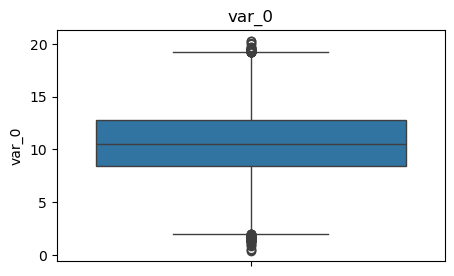

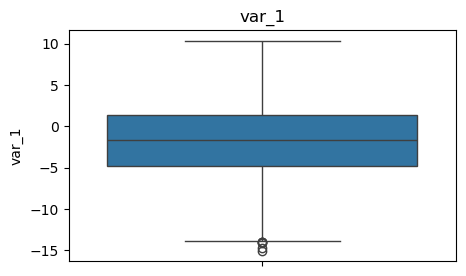

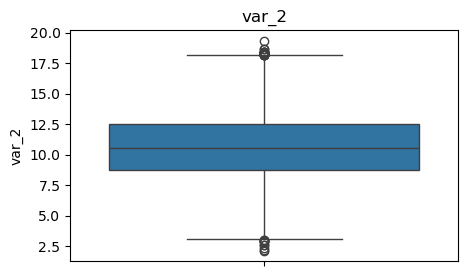

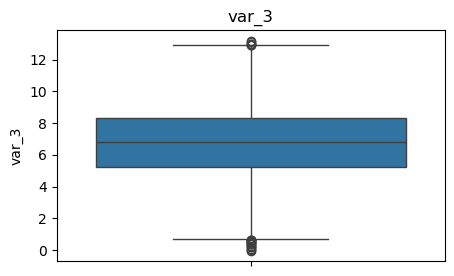

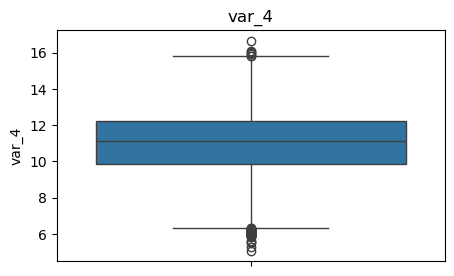

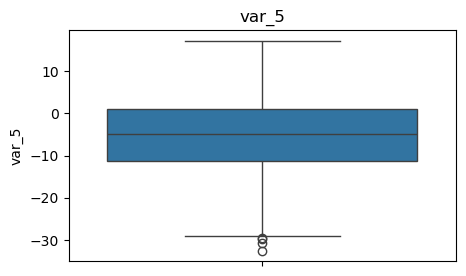

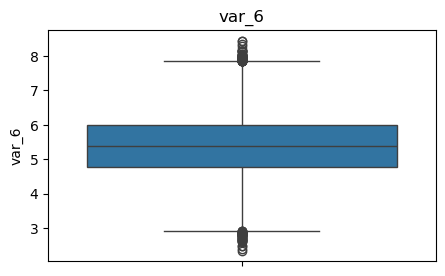

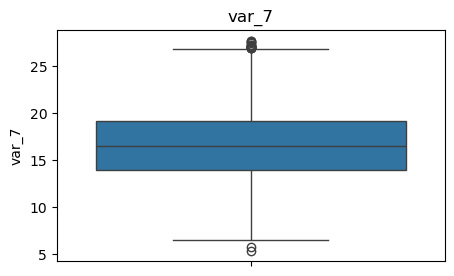

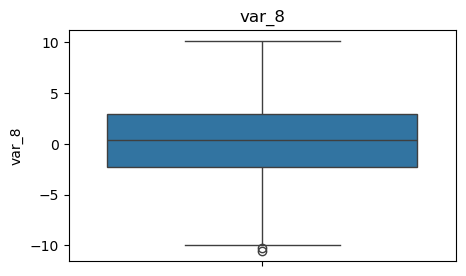

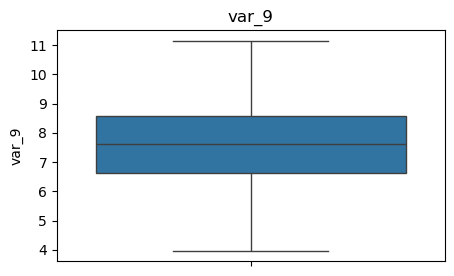

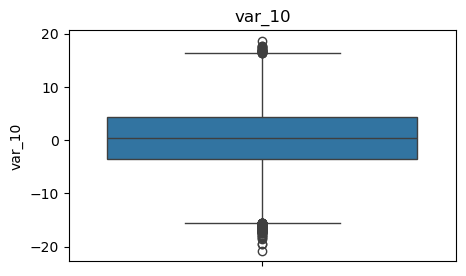

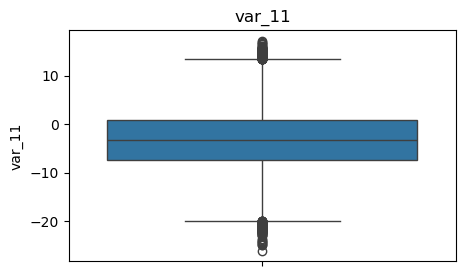

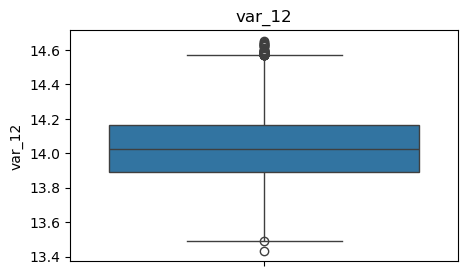

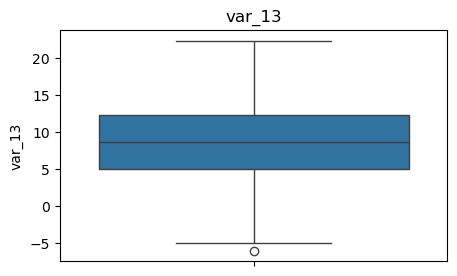

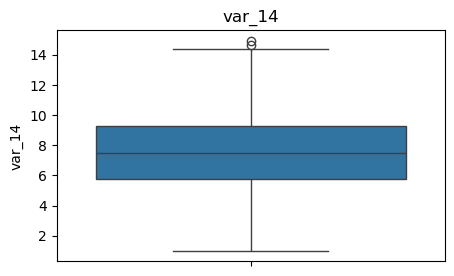

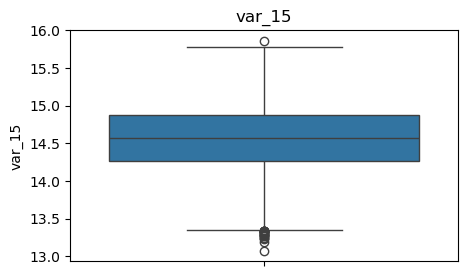

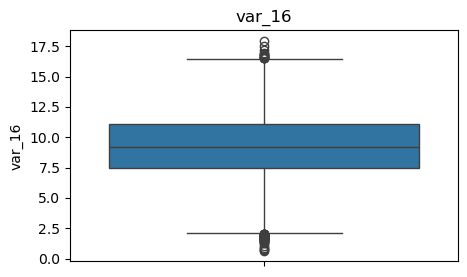

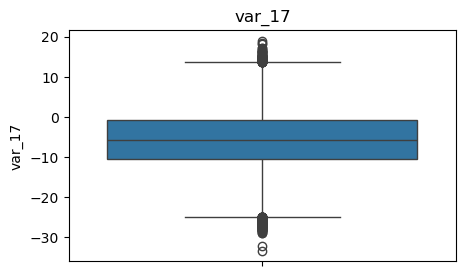

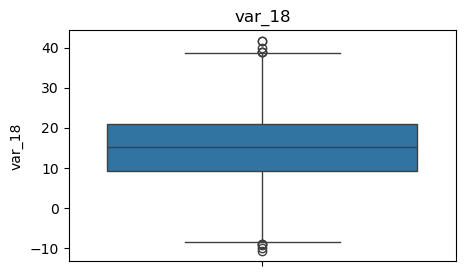

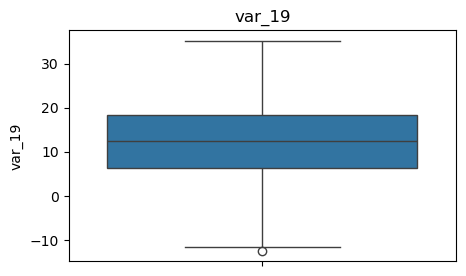

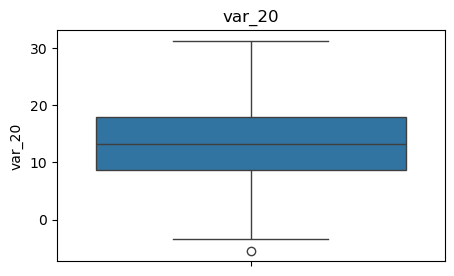

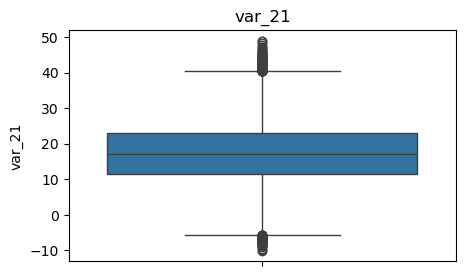

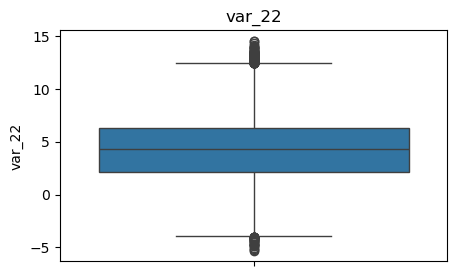

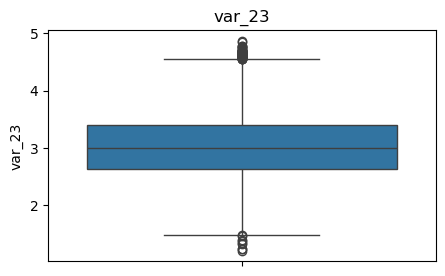

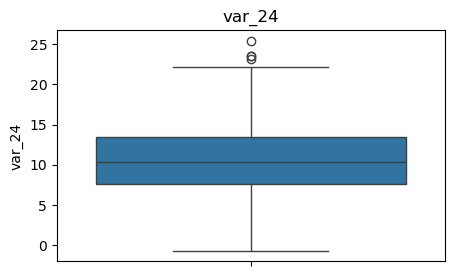

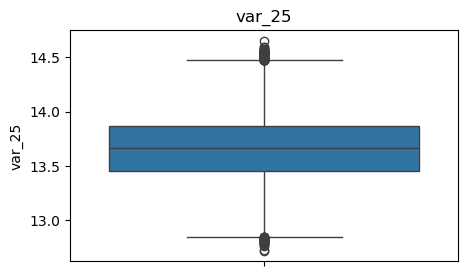

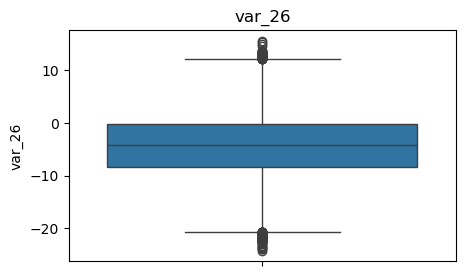

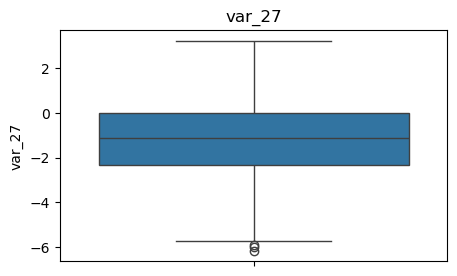

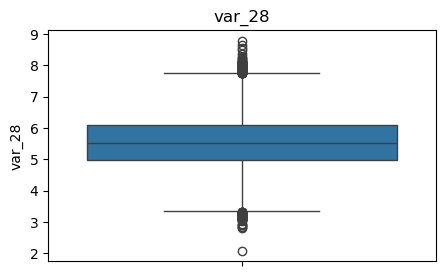

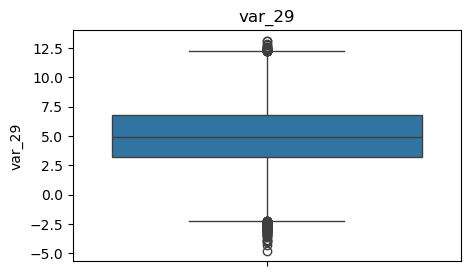

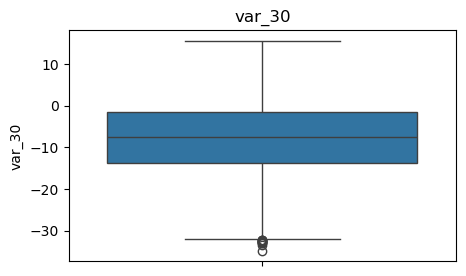

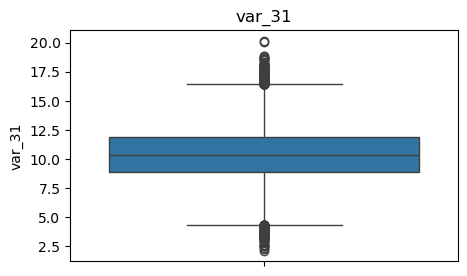

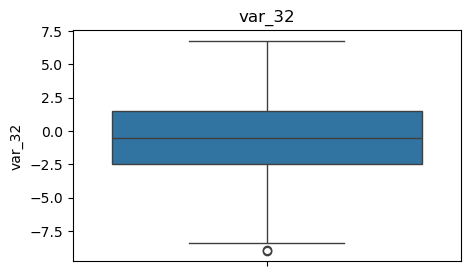

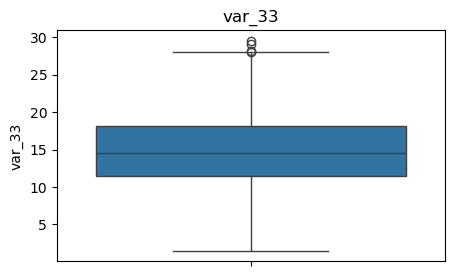

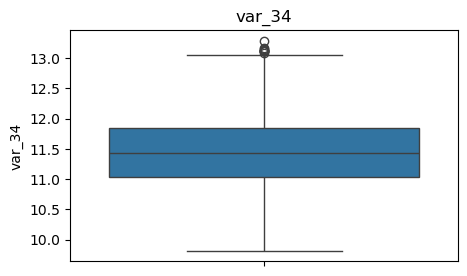

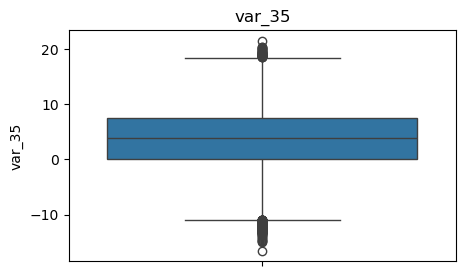

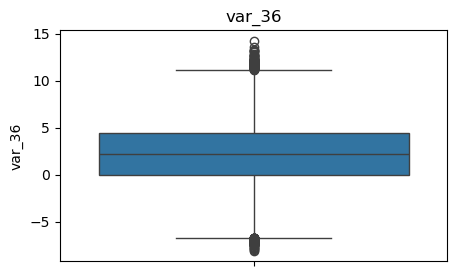

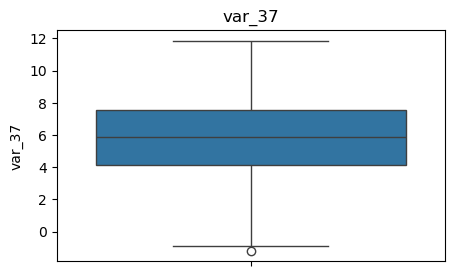

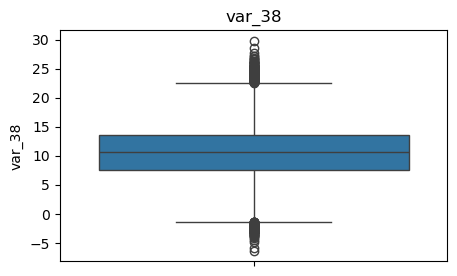

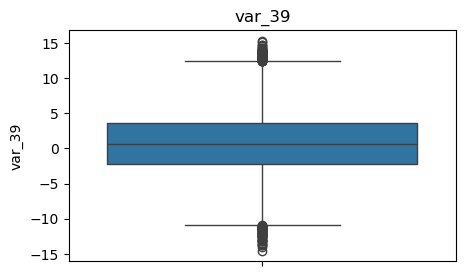

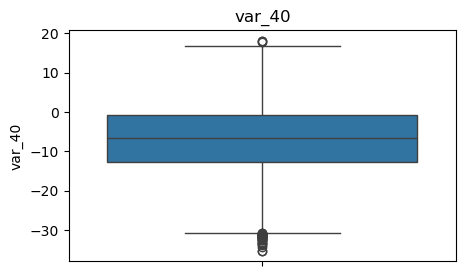

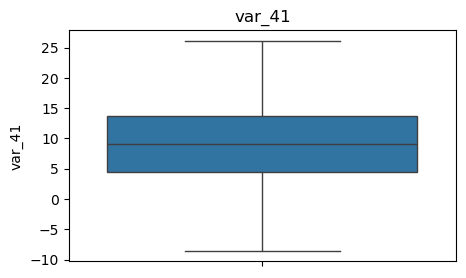

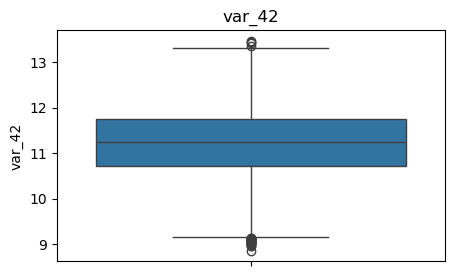

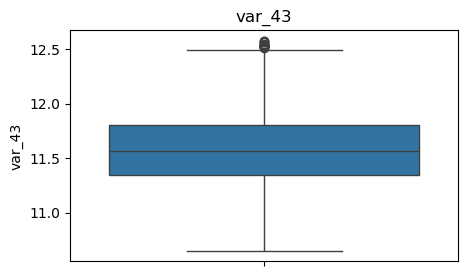

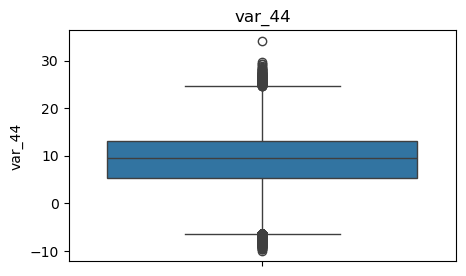

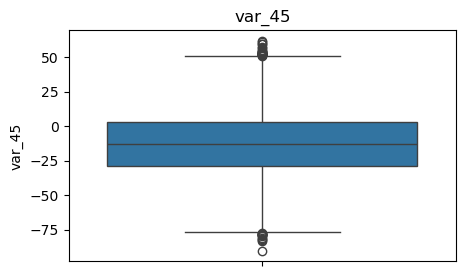

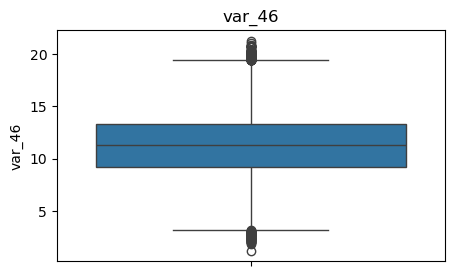

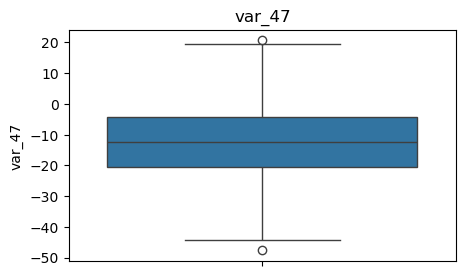

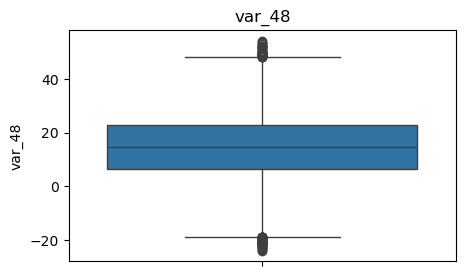

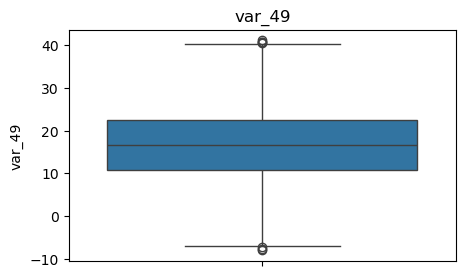

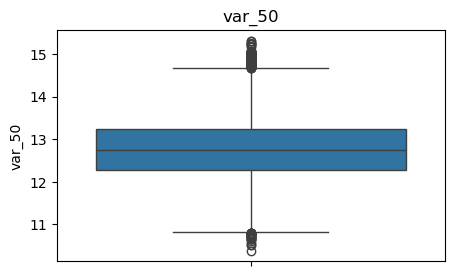

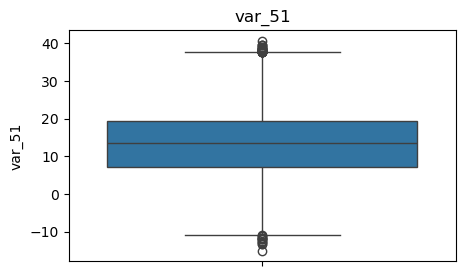

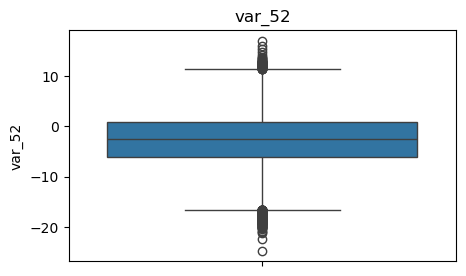

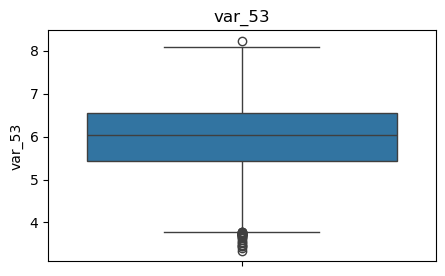

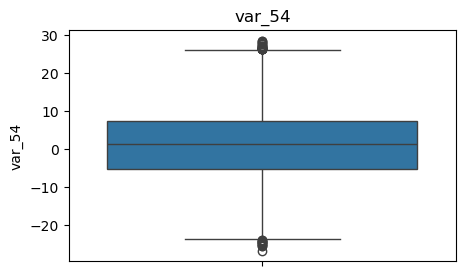

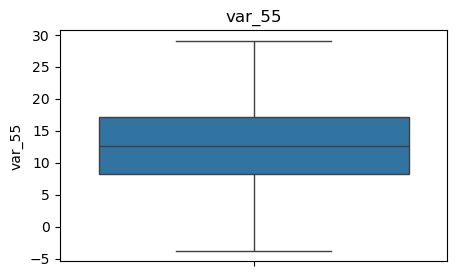

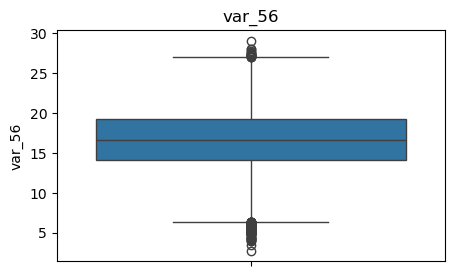

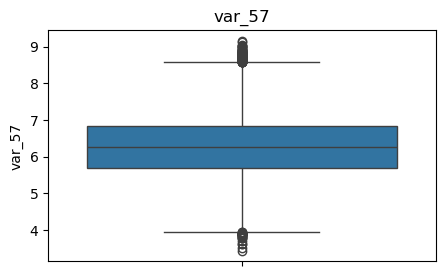

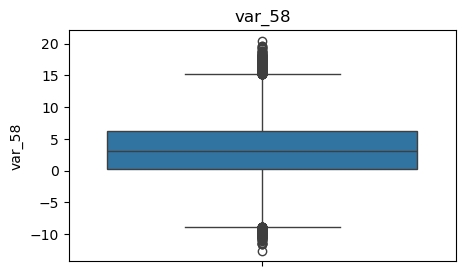

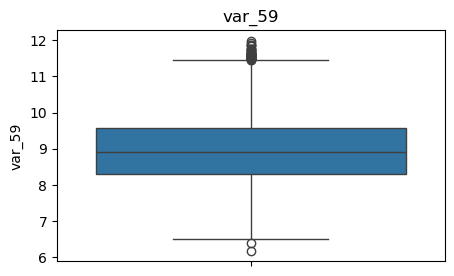

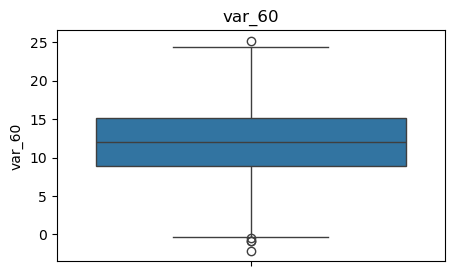

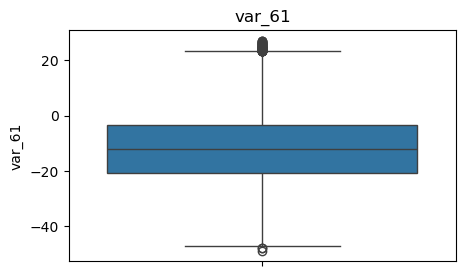

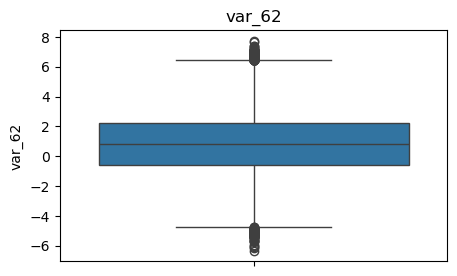

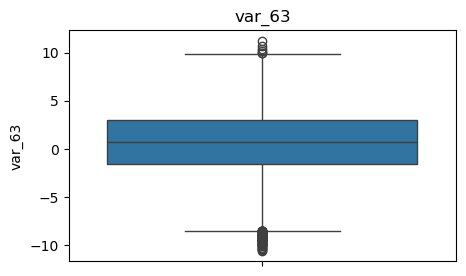

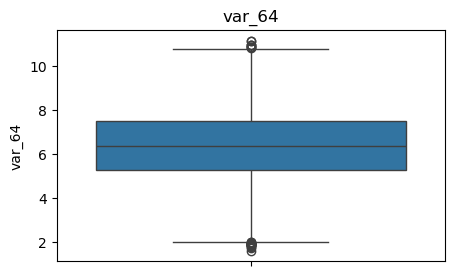

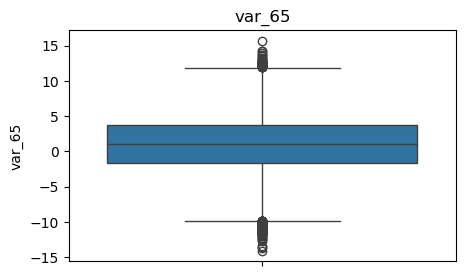

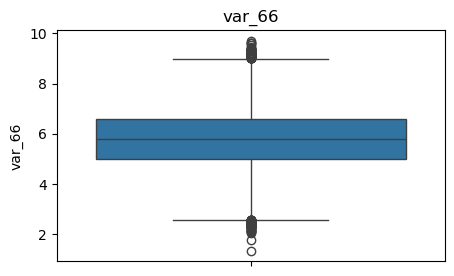

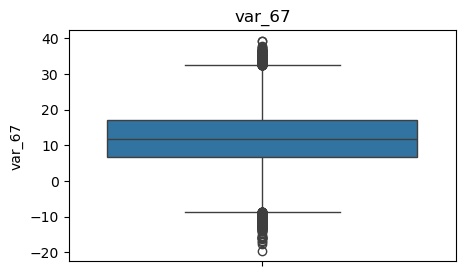

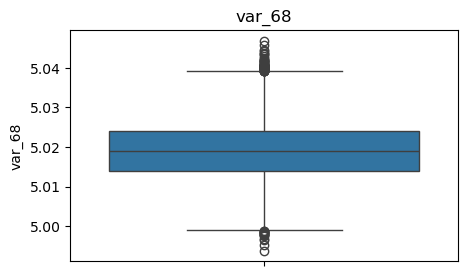

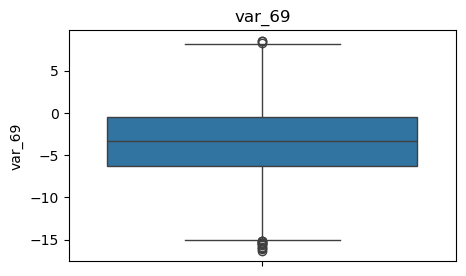

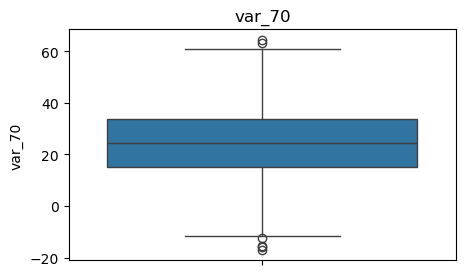

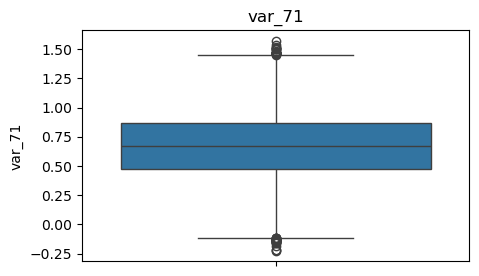

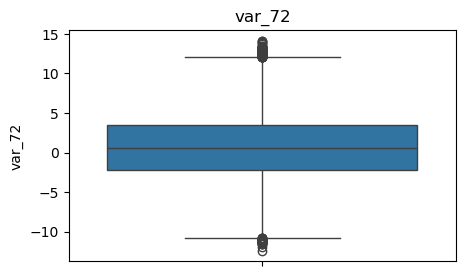

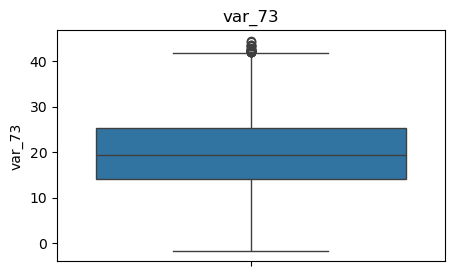

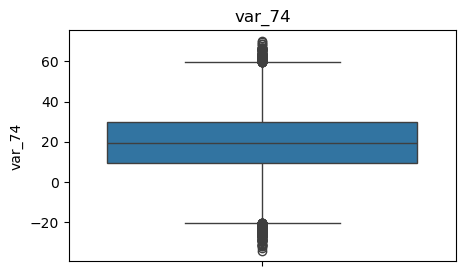

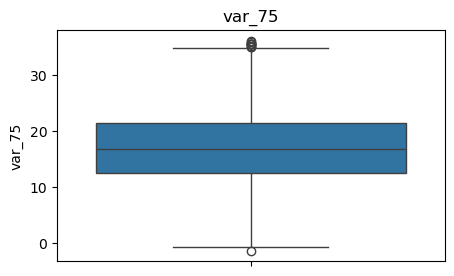

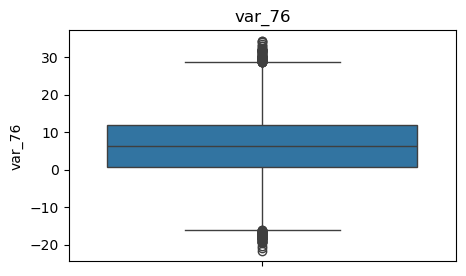

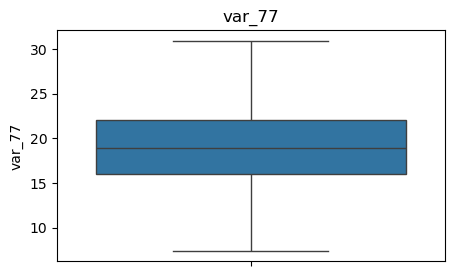

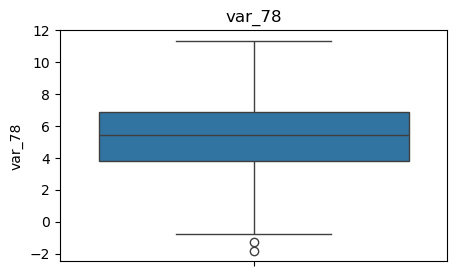

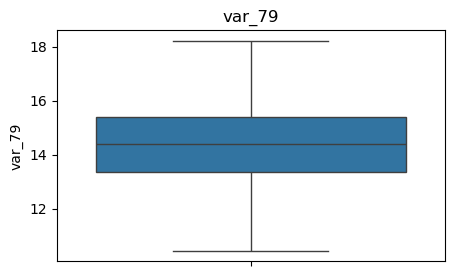

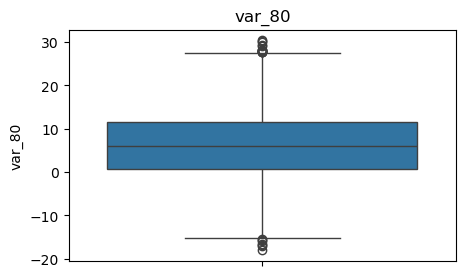

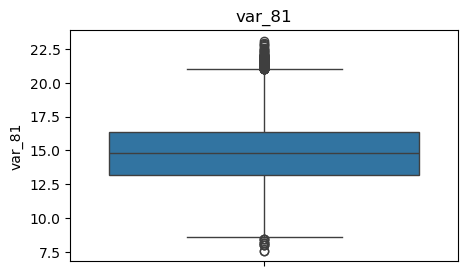

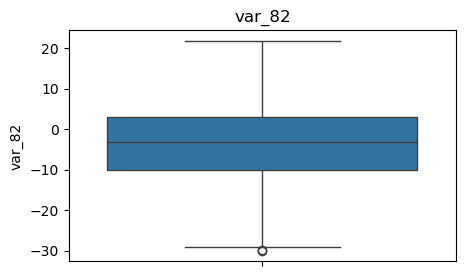

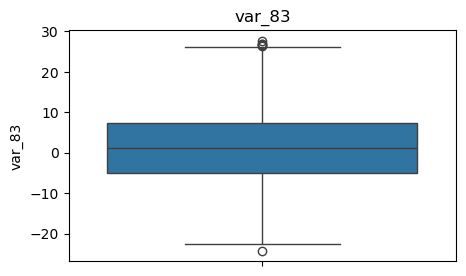

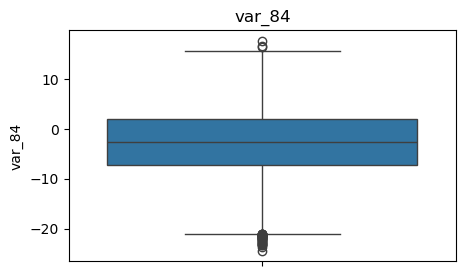

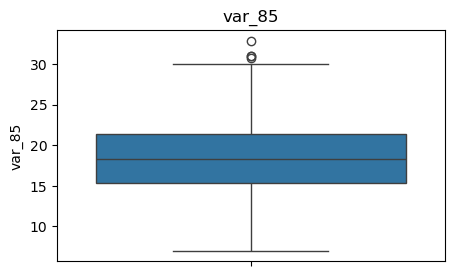

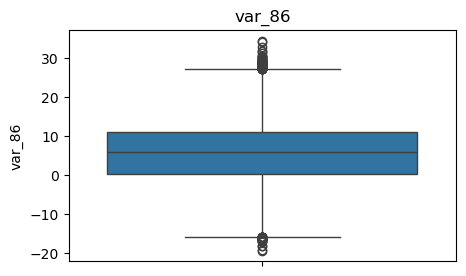

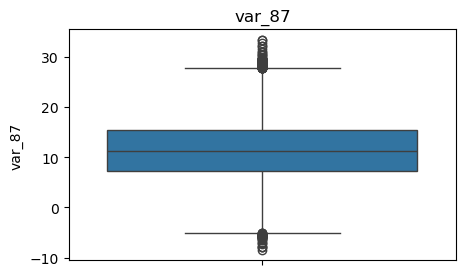

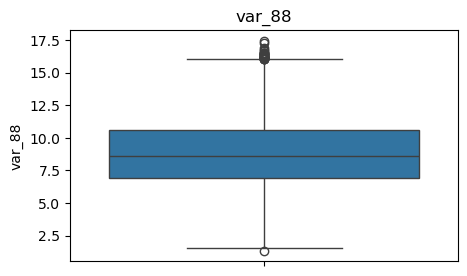

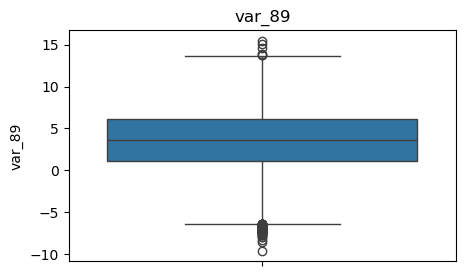

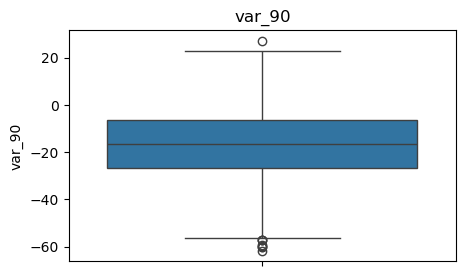

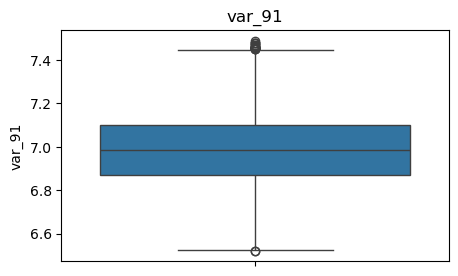

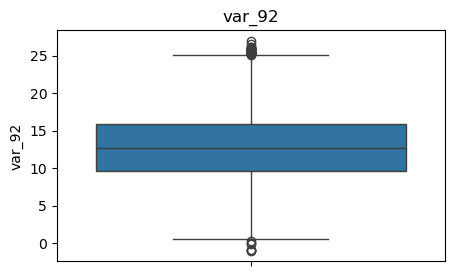

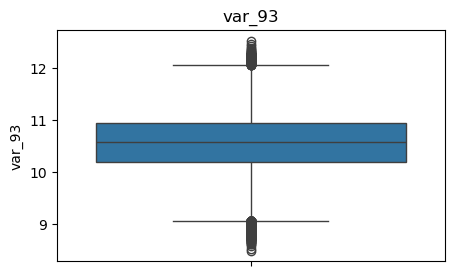

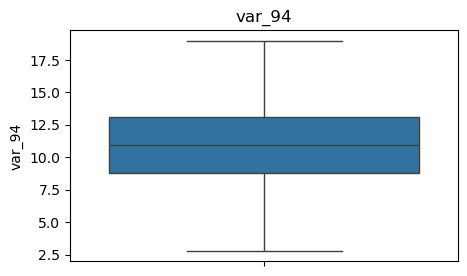

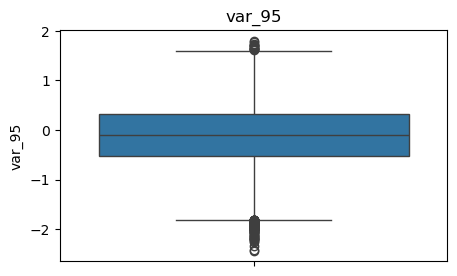

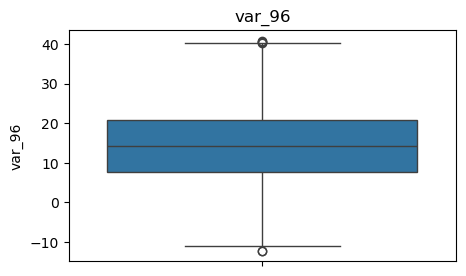

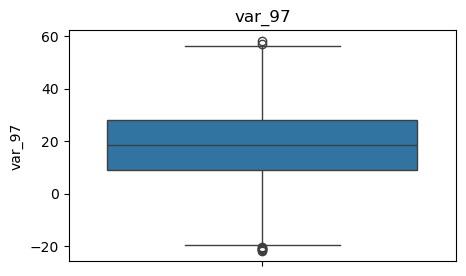

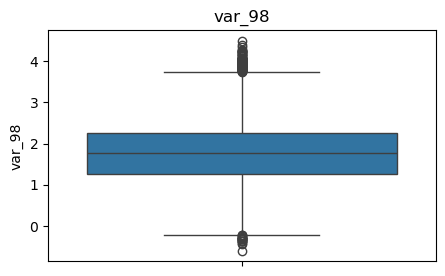

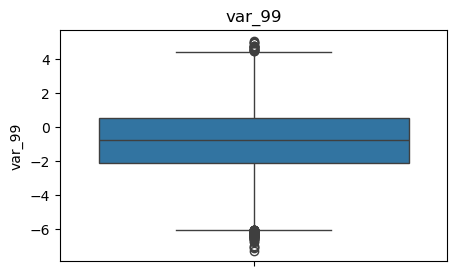

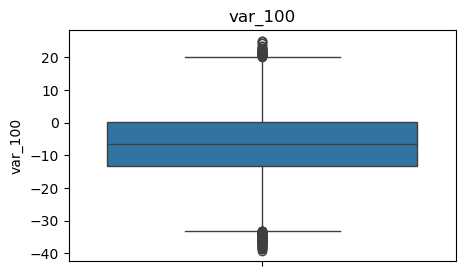

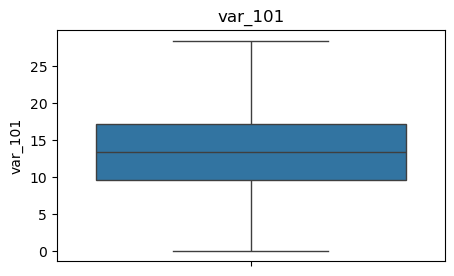

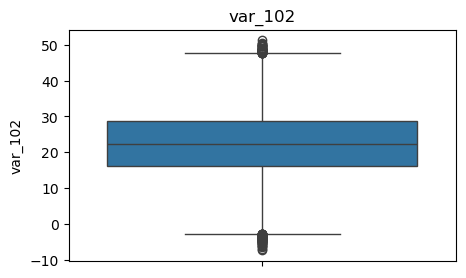

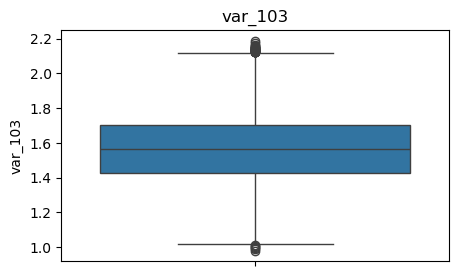

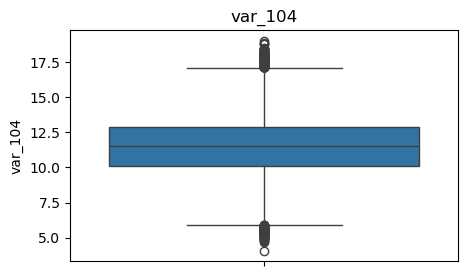

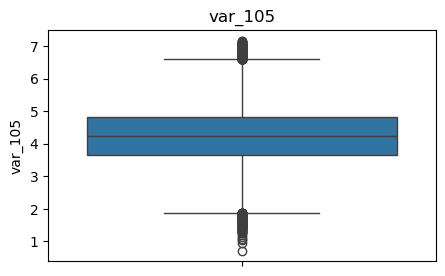

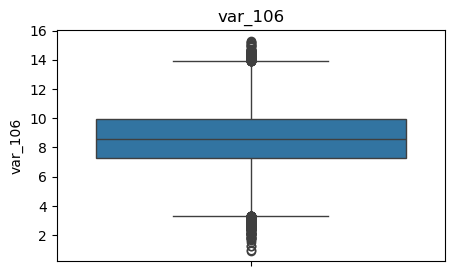

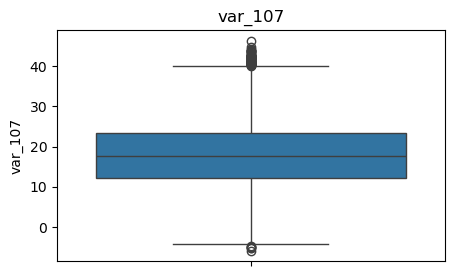

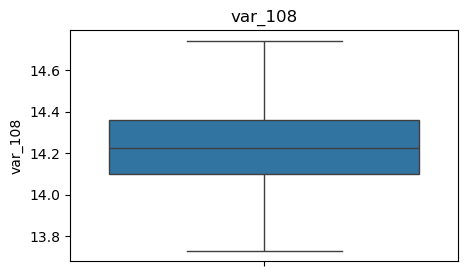

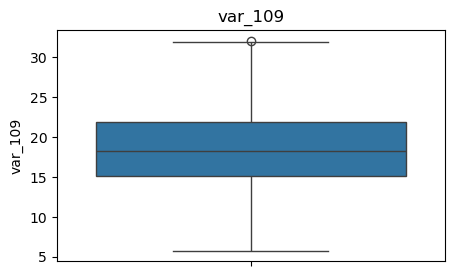

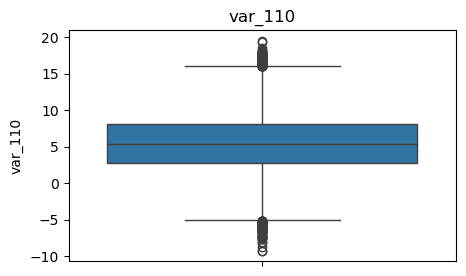

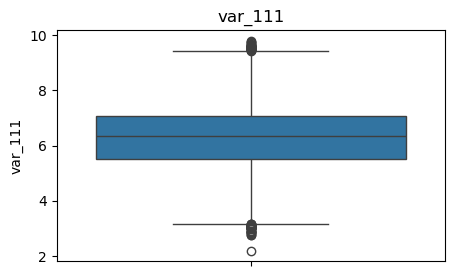

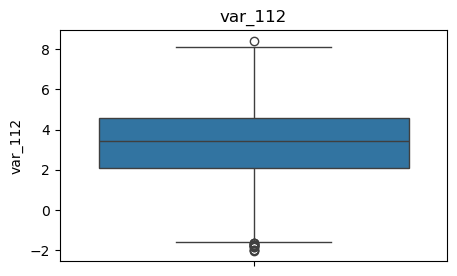

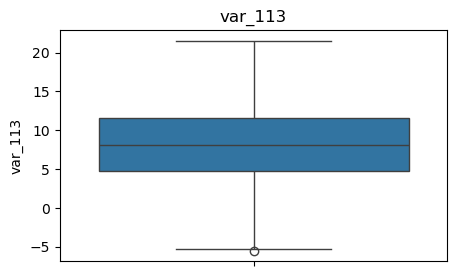

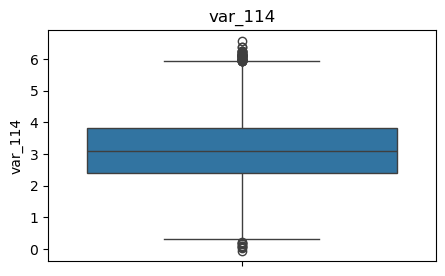

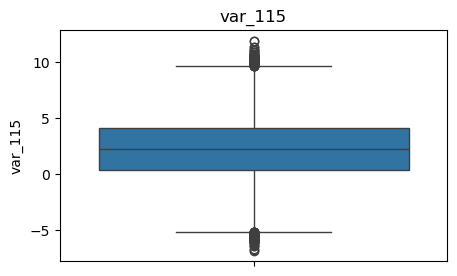

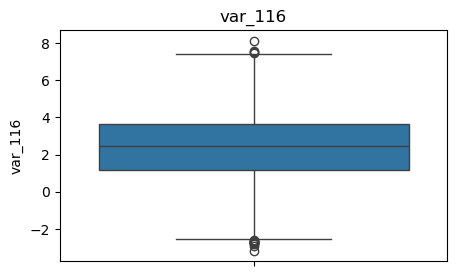

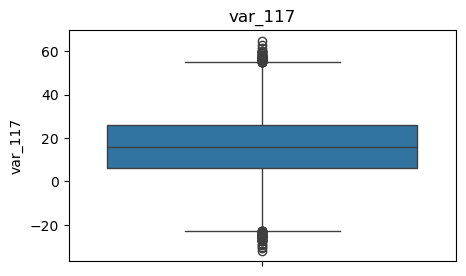

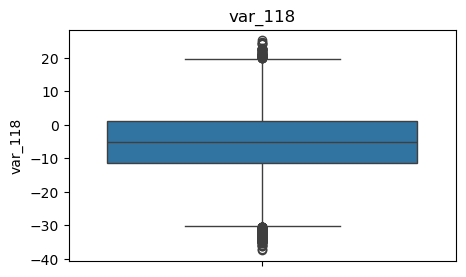

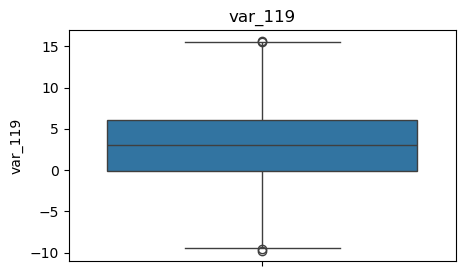

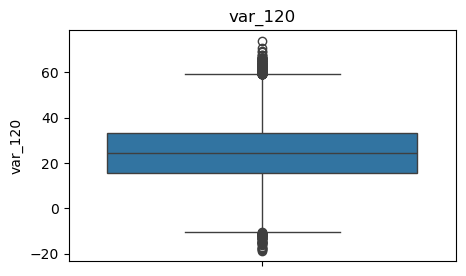

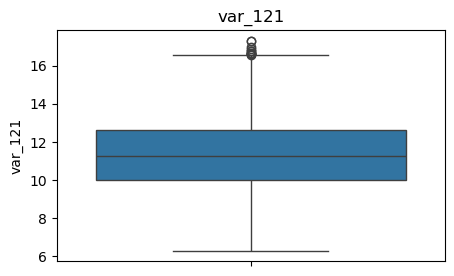

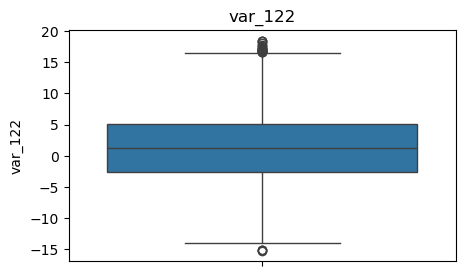

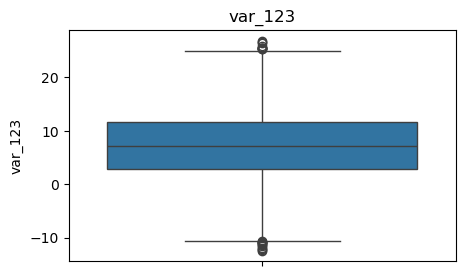

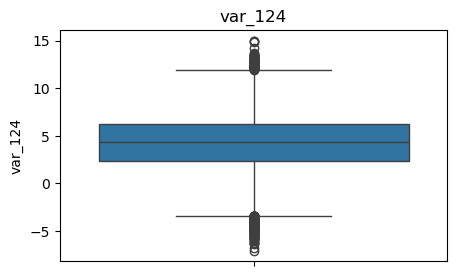

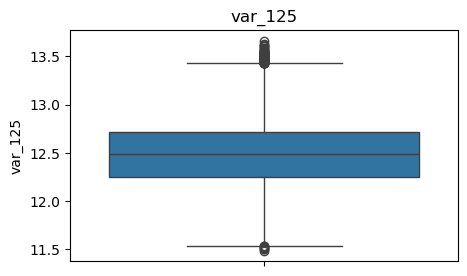

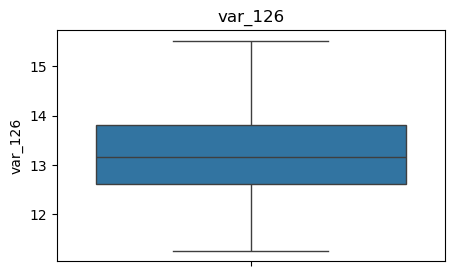

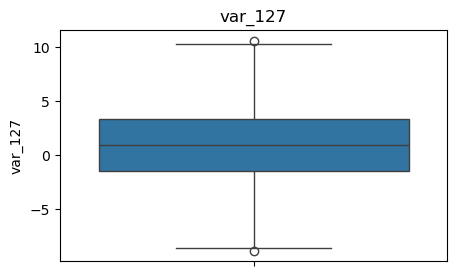

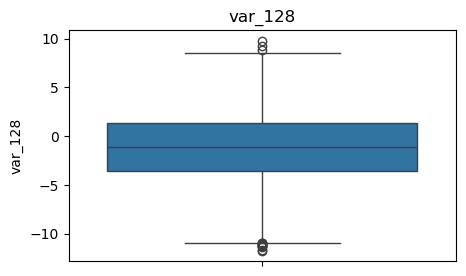

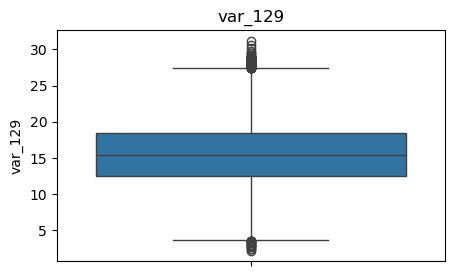

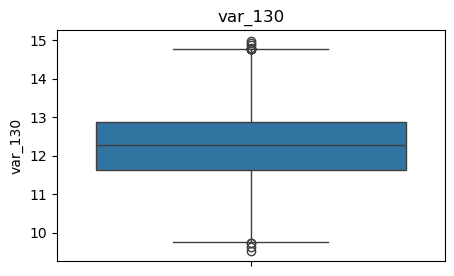

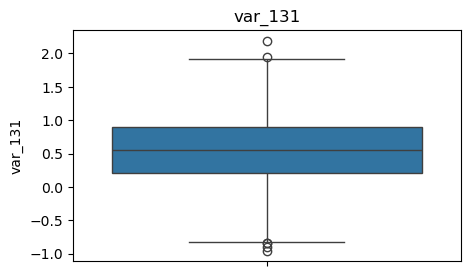

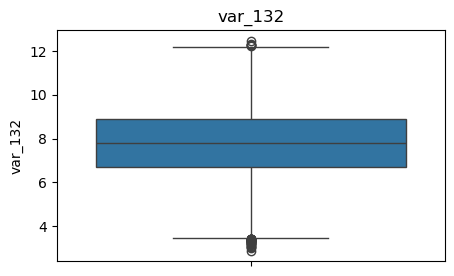

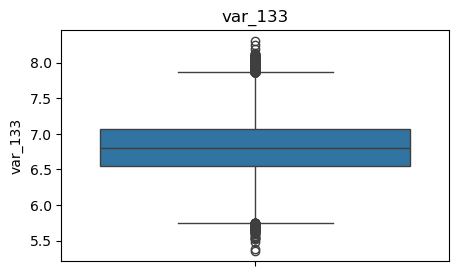

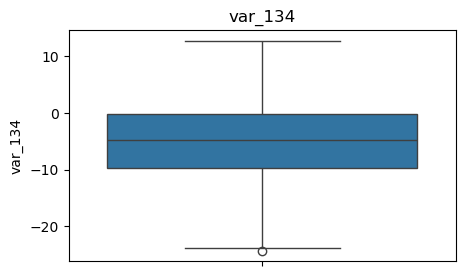

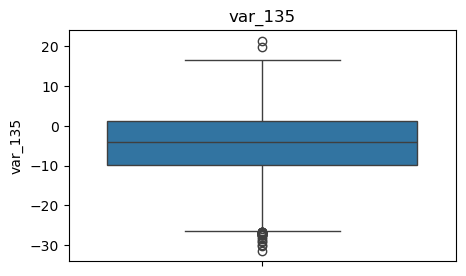

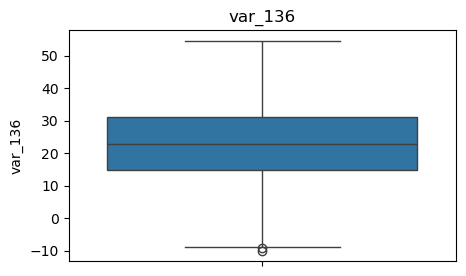

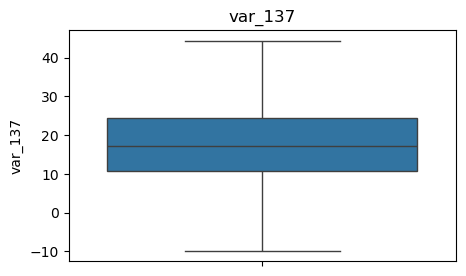

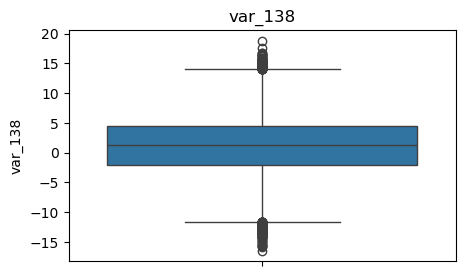

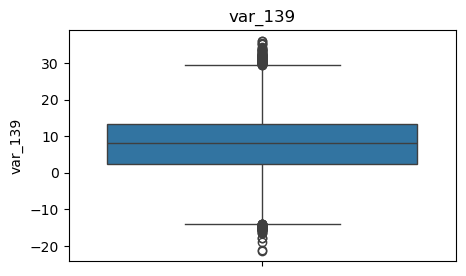

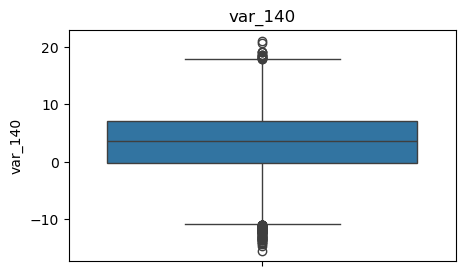

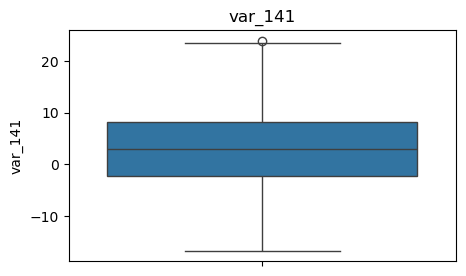

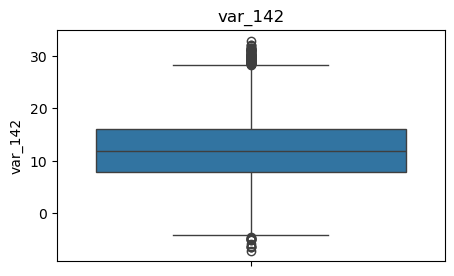

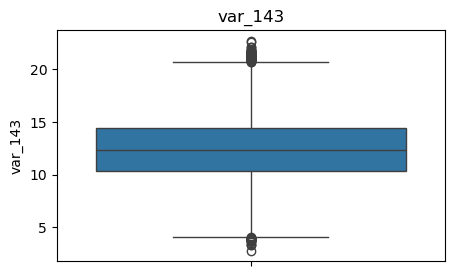

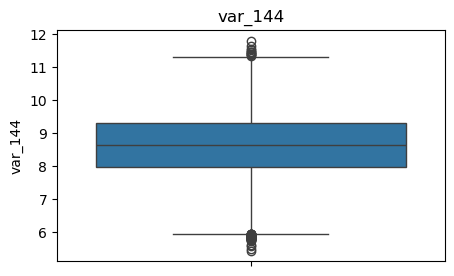

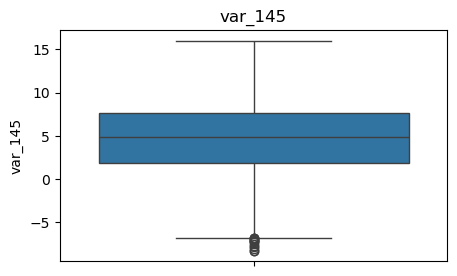

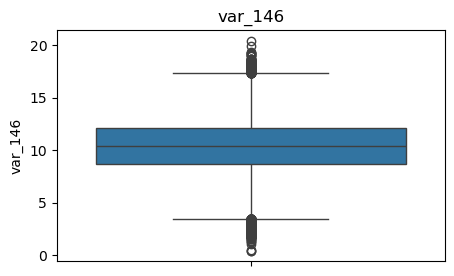

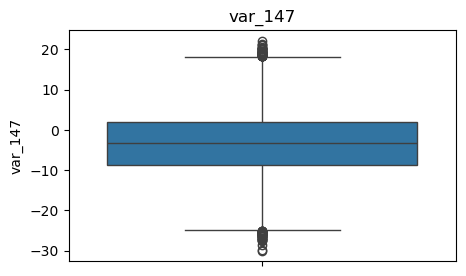

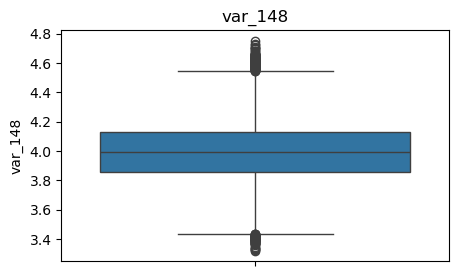

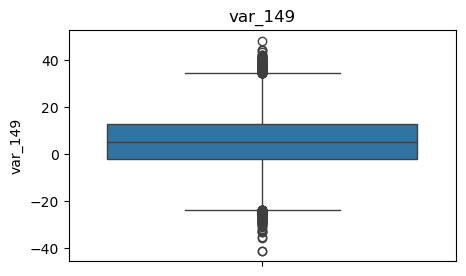

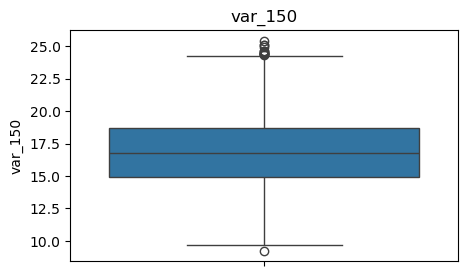

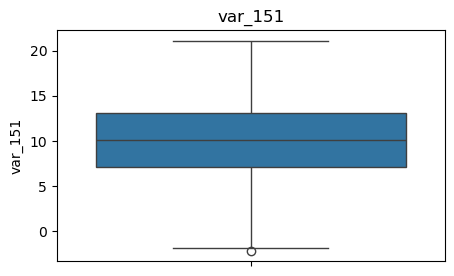

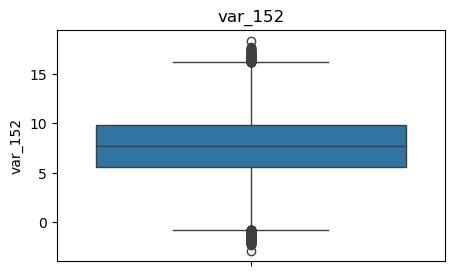

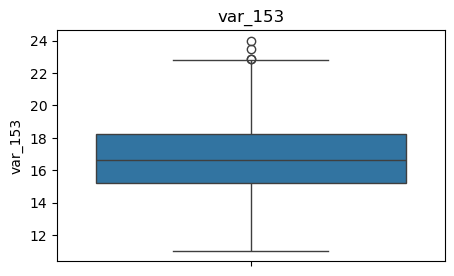

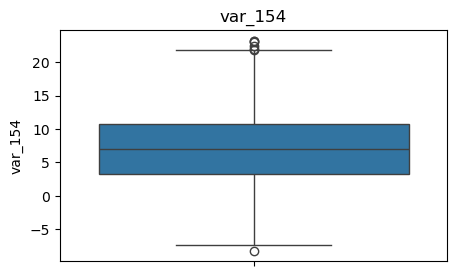

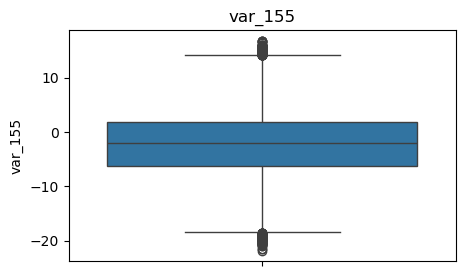

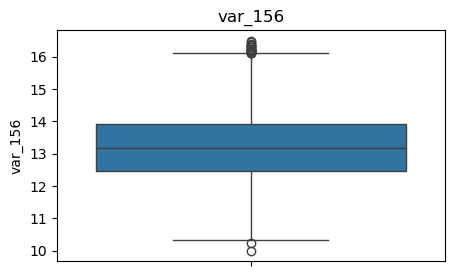

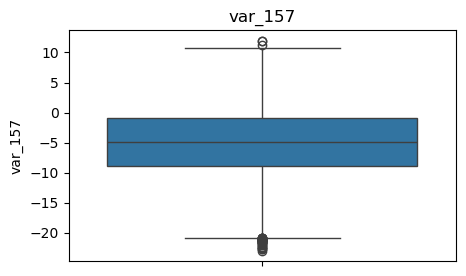

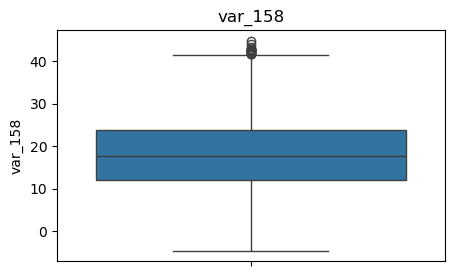

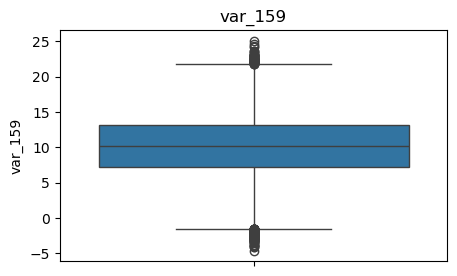

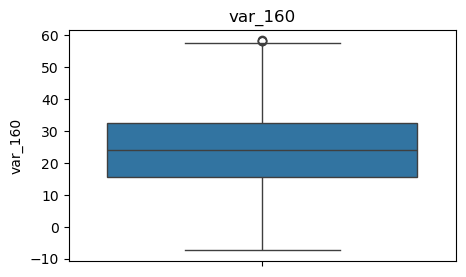

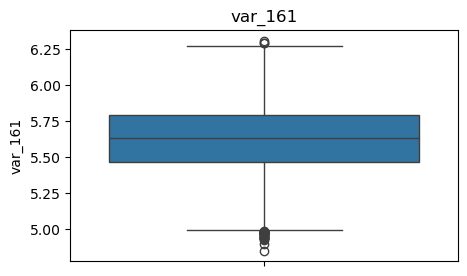

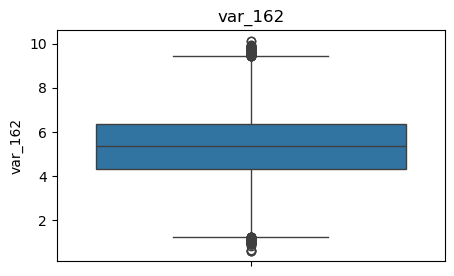

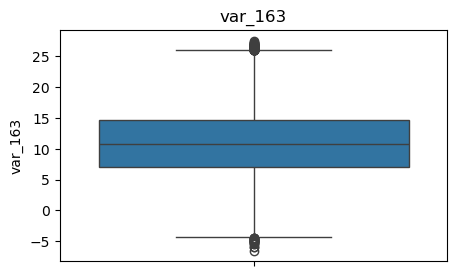

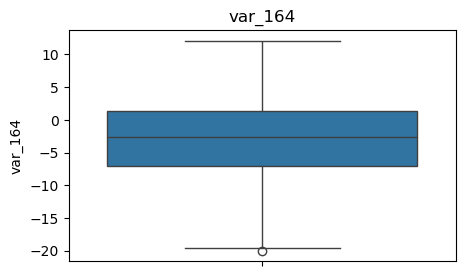

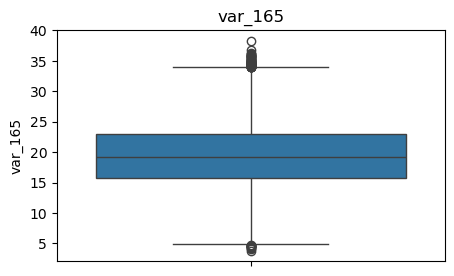

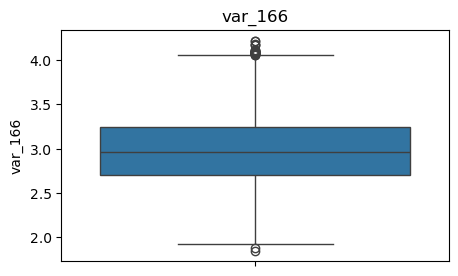

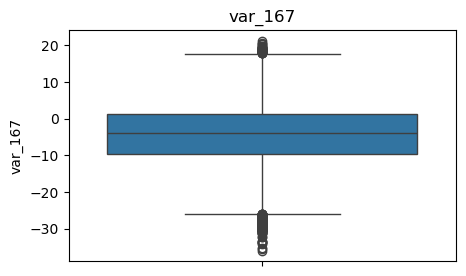

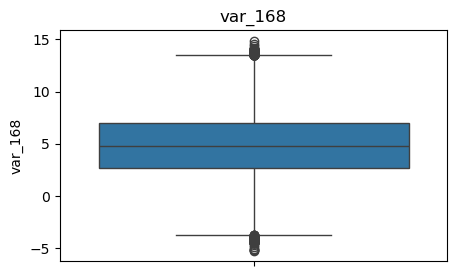

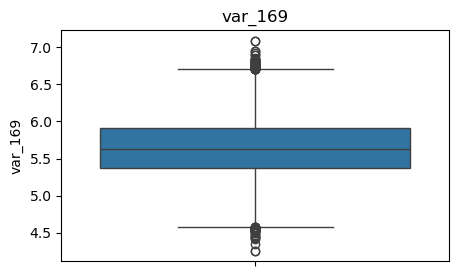

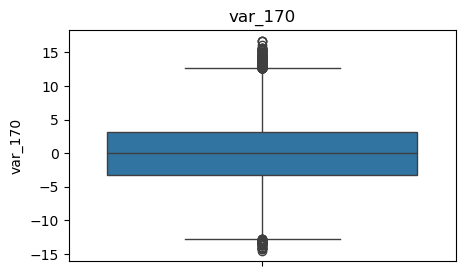

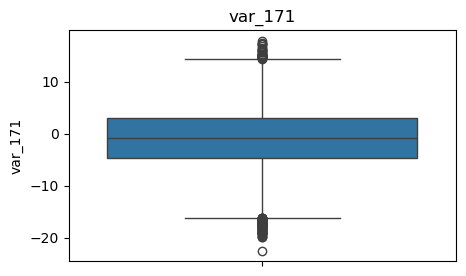

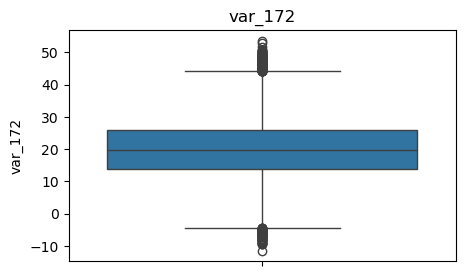

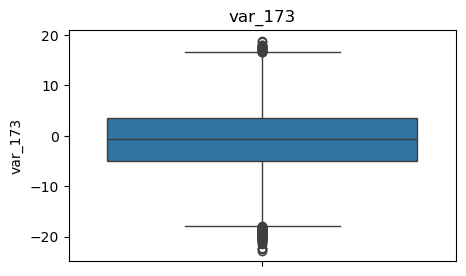

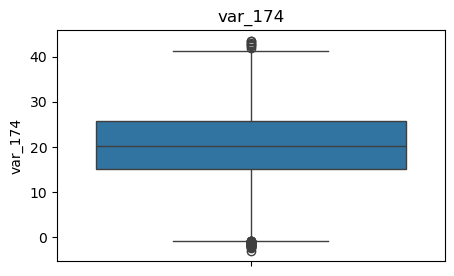

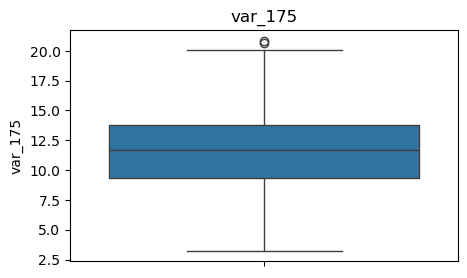

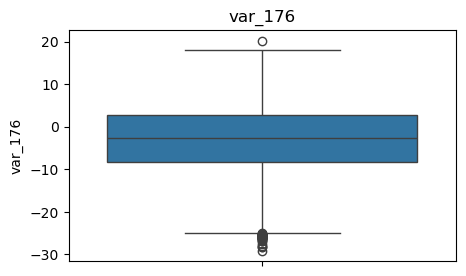

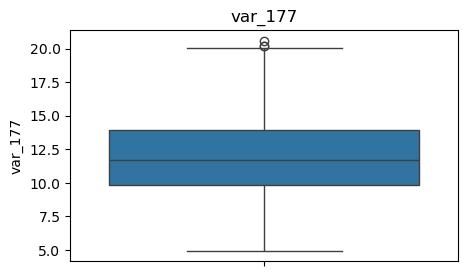

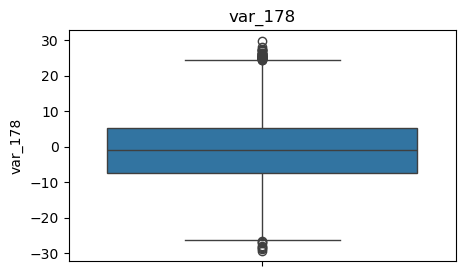

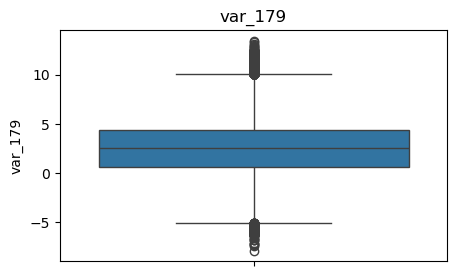

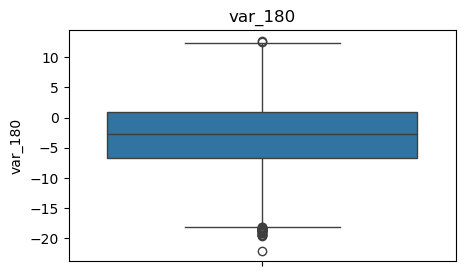

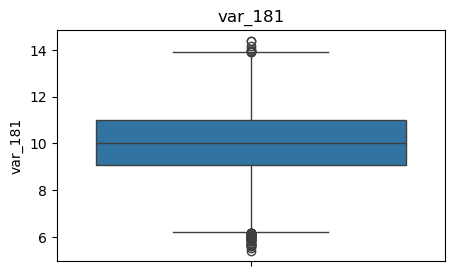

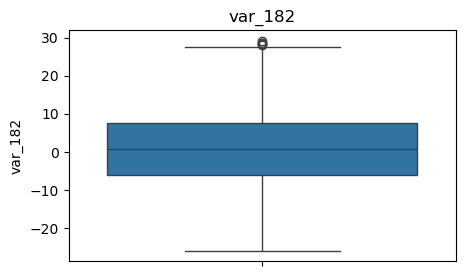

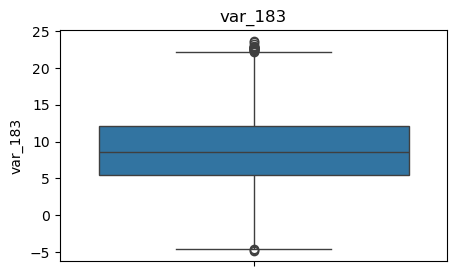

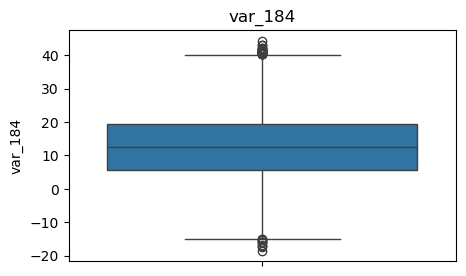

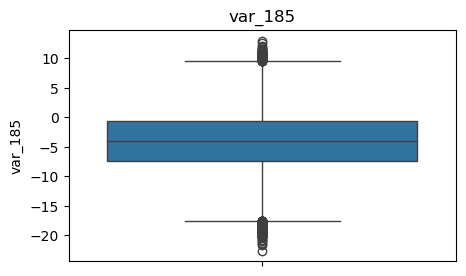

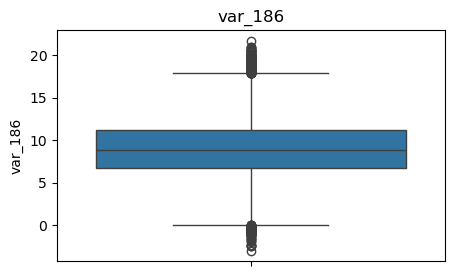

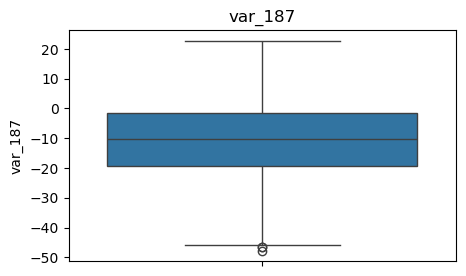

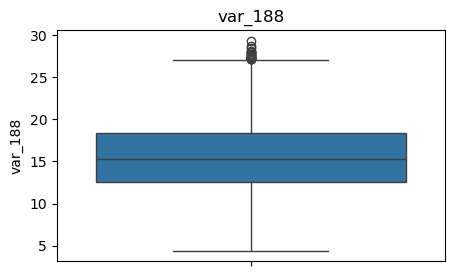

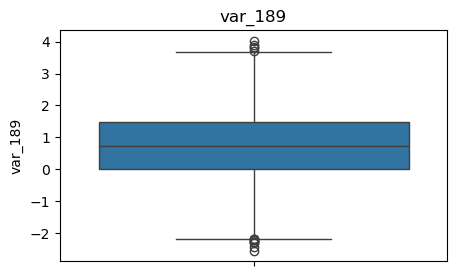

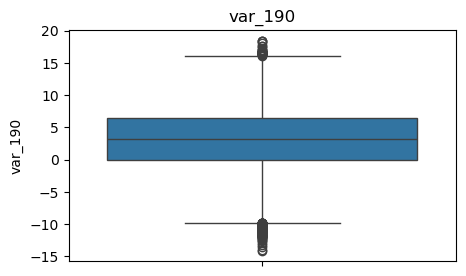

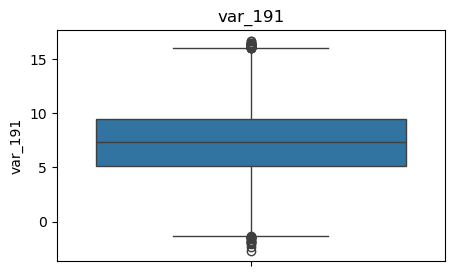

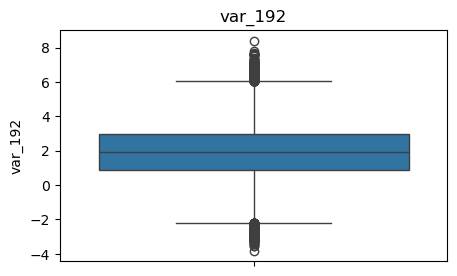

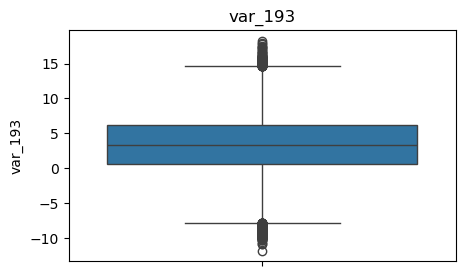

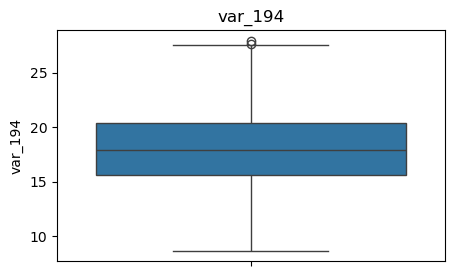

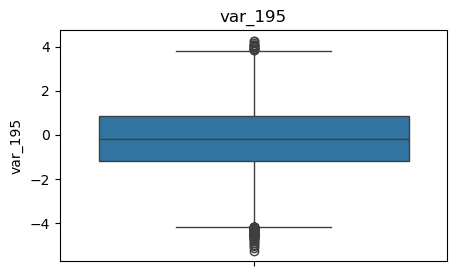

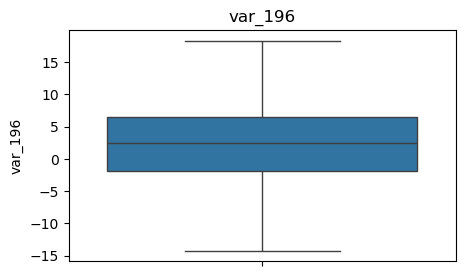

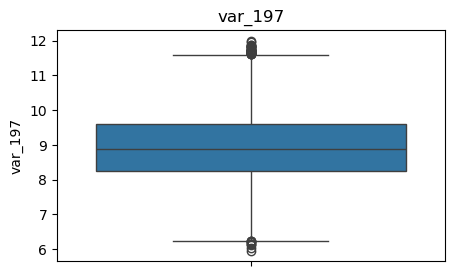

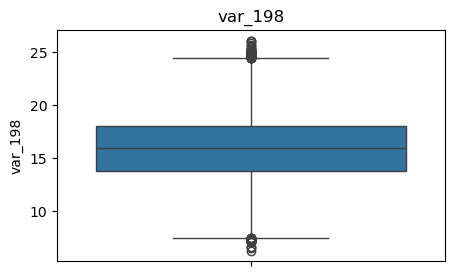

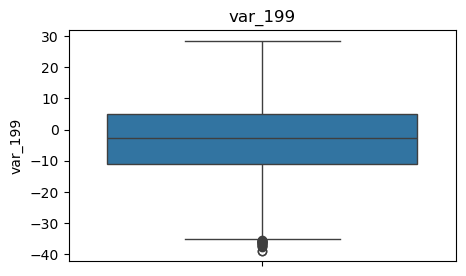

In [23]:
# Box plots to identify outliers
for column in train:
    plt.figure(figsize=(5, 3))
    sns.boxplot(data[column])
    plt.title(column)
    plt.show()

* Find the correlations to drop feature

In [24]:
corr_matrix=train.corr()
print('Max_corr within all variables correlations :', np.sort(corr_matrix)[:,-2:-1].max())
# sorts the correlation matrix and selects the second-to-last correlation for each column and returns the maximum value
# among these selected correlations.

Max_corr within all variables correlations : 0.009713658349533916


* Above reflects that all the variables are almost independent and 
* Can not drop any feature from the dataset since there are no highly correlations in the correlation matrix (corr_matrix)

In [25]:
# Calculate kurtosis for each column
kurtosis_values = train.kurtosis()

# Define tolerance for "approximately zero"
tolerance = 0.1

# Check if kurtosis is approximately 0
kurtosis_approx_zero = (kurtosis_values.abs() <= tolerance).nunique()
kurtosis_approx_zero

2

In [26]:
kurtosis=train.kurtosis()
Leptokurtic=kurtosis[kurtosis>0]
Platykurtic =kurtosis[kurtosis<0]
print(Leptokurtic.nunique())
print(Platykurtic.nunique())

0
200


* Kurtosis < 0: The distribution is platykurtic, meaning it has light tails and fewer outliers.
* this is a binary classification task since treebased algorithm are robust to outliers as well as the logistic regression 
* is generally more robust to outliers compared to linear regression and
* Kurtosis < 0  counts 200 outof 201, The distribution is platykurtic,[it has light tails and fewer outliers] outlier handling is not performed.

#### Handling outliers

In [27]:
# Extracting features
train_x = data.iloc[:,1:]
# Calculate the Interquartile Range (IQR)
q3=train_x.quantile(.75)
q1= train_x.quantile(.25)
IQR = q3-q1
# Print the Original Shape of the Data
print("data.shape:", data.shape)

data.shape: (200000, 202)


In [28]:
# Identify and Keep Non-Outliers (data_in)
data_in = data[~((train_x < (q1 - 1.5 * IQR)) | (train_x > (q3 + 1.5 * IQR))).any(axis=1)]
# contain rows without outliers

# Identify and Keep Outliers (data_out)
data_out = data[((train_x < (q1 - 1.5 * IQR)) | (train_x > (q3 + 1.5 * IQR))).any(axis=1)]
# Contains rows identified as outliers.

In [29]:
data_out

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
13,train_13,1,16.3699,1.5934,16.7395,7.3330,12.1450,5.9004,4.8222,20.9729,...,7.4002,7.4031,4.3989,4.0978,17.3638,-1.3022,9.6846,9.0419,15.6064,-10.8529
14,train_14,0,13.8080,5.0514,17.2611,8.5120,12.8517,-9.1622,5.7327,21.0517,...,1.0740,8.3220,3.2619,1.6738,17.4797,-0.0257,-3.5323,9.3439,24.4479,-5.1110
19,train_19,0,4.4090,-0.7863,15.1828,8.0631,11.2831,-0.7356,6.3801,16.0218,...,5.9745,6.3267,2.5156,8.9878,16.0550,-2.1962,8.3985,9.1711,14.7352,3.9133
29,train_29,1,5.3301,-2.6064,13.1913,3.1193,6.6483,-6.5659,5.9064,15.2341,...,5.9215,7.9676,2.3405,1.1482,23.2168,-2.0105,3.7600,9.4513,17.4105,-14.6897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199986,train_199986,1,12.0298,-8.7800,7.7071,7.4015,9.2305,-16.2174,5.9064,17.9268,...,16.7461,3.1249,-0.3943,8.4059,14.3367,3.0991,4.3853,8.8019,15.0031,-0.3659
199987,train_199987,0,8.0438,-1.9184,13.1498,9.2027,8.9886,2.7531,4.2194,18.1138,...,7.1818,10.8590,3.5770,1.2627,16.9983,-1.5922,-3.5687,8.1765,19.5095,-13.3091
199990,train_199990,1,14.1475,1.8568,11.0066,3.6779,12.1944,-16.5936,5.3217,14.8508,...,-6.4708,4.7287,1.9034,7.2324,20.6047,1.7170,-4.0032,9.1627,13.8077,-1.9646
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388


In [30]:
#Print the Shapes of the Inlier and Outlier DataFrames
print("data_in.shape:", data_in.shape)
print("data_out.shape:", data_out.shape)
#showing how many rows and columns are in the datasets containing non-outliers (data_in) and
# outliers (data_out), respectively.

data_in.shape: (157999, 202)
data_out.shape: (42001, 202)


In [31]:
data_in['target'].value_counts()
data_out['target'].value_counts()

target
0    21903
1    20098
Name: count, dtype: int64

* All the outliers include our class1 target [t1], so we cannot remove them.

* Now we are moving to the dimensionality reduction techniques PCA

* Using Elbow Method to determine the right number of components to be retain.

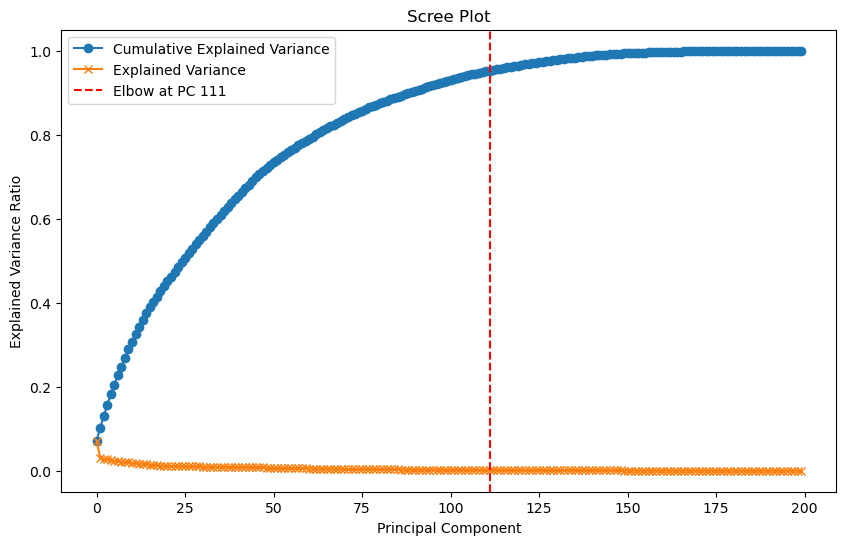

In [32]:
# feature extraction
pca = PCA().fit(train)
EVR=pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_evr = np.cumsum(EVR)

# Define the elbow point: find the number of components to retain 95% variance
elbow = np.argmax(cumulative_evr >= 0.95) + 1
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(EVR), marker='o', label='Cumulative Explained Variance')
plt.plot(EVR, marker='x', label='Explained Variance')
plt.axvline(x=elbow, color='r', linestyle='--', label=f'Elbow at PC {elbow}')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.legend(loc='best')
plt.show()

Once identified the elbow point at 111 principal components from the dataset using PCA, the next step is to reduce the dimensionality of our dataset to these 111 components. This process will create a new set of features that capture the majority of the variance in the data with fewer components, making the data easier to work with and potentially improving the performance of machine learning models.

In [33]:
x=train
y=data['target']

In [34]:
# Using Stratified sampling
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=40)

In [35]:
#standerdize the features
scaled=StandardScaler()
x_train_scaled=scaled.fit_transform(x_train)
x_test_scaled=scaled.transform(x_test)

In [36]:
pca = PCA(n_components=111)
x_train_pca=pca.fit_transform(x_train_scaled)
x_test_pca=pca.transform(x_test_scaled)

In [ ]:
# Train Random Forest model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=60,random_state=40)
model.fit(x_train_pca, y_train)

In [38]:
y_pred=model.predict(x_test_pca)

In [39]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
train_accuracy = accuracy_score(y_test, y_pred)
print(f'Training Accuracy: {train_accuracy:.2f}')
print('***********************')
# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('**********************')
# Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.91
***********************
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     36005
           1       0.64      0.20      0.30      3995

    accuracy                           0.91     40000
   macro avg       0.78      0.59      0.63     40000
weighted avg       0.89      0.91      0.89     40000

**********************
Confusion Matrix:
[[35565   440]
 [ 3215   780]]


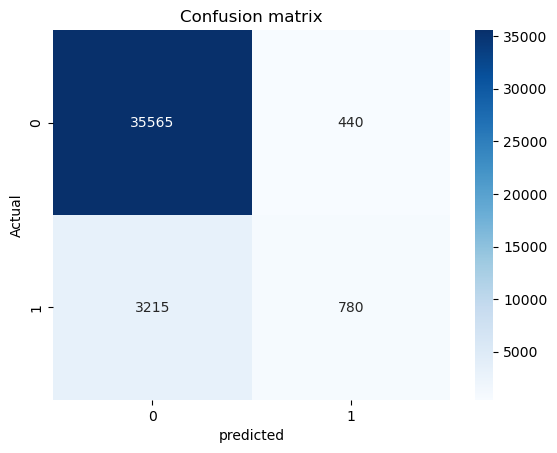

In [41]:
# visualising predictions
# without balancing 
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [42]:
y_test_pred=model.predict(x_test_pca)
test_accuracy=accuracy_score(y_test,y_test_pred)
print(f'Test Accuracy:{test_accuracy:.2f}')

Test Accuracy:0.91


In [43]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train_pca, y_train)

LogisticRegression()

In [44]:
y_pred_LR=model.predict(x_test_pca)

In [45]:
 as_LR=accuracy_score(y_test, y_pred_LR)
 as_LR

0.908625

In [46]:
# Accuracy
train_accuracy_LR = accuracy_score(y_test, y_pred_LR)
print(f'Training Accuracy: {train_accuracy_LR:.2f}')
print('***********************')
# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred_LR))
print('**********************')
# Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_LR))

Training Accuracy: 0.91
***********************
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     36005
           1       0.64      0.20      0.30      3995

    accuracy                           0.91     40000
   macro avg       0.78      0.59      0.63     40000
weighted avg       0.89      0.91      0.89     40000

**********************
Confusion Matrix:
[[35565   440]
 [ 3215   780]]


In [47]:
from sklearn.tree import DecisionTreeClassifier
# Train Decision Tree Model
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(x_train_pca, y_train)

DecisionTreeClassifier(random_state=42)

In [48]:
y_pred_DT=model.predict(x_test_pca)

In [49]:
# Accuracy
train_accuracy_DT = accuracy_score(y_test, y_pred_DT)
print(f'Training Accuracy: {train_accuracy_DT:.2f}')
print('***********************')
# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred_DT))
print('**********************')
# Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_DT))

Training Accuracy: 0.91
***********************
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     36005
           1       0.64      0.20      0.30      3995

    accuracy                           0.91     40000
   macro avg       0.78      0.59      0.63     40000
weighted avg       0.89      0.91      0.89     40000

**********************
Confusion Matrix:
[[35565   440]
 [ 3215   780]]


### challenges we faced
since we getting the exact same classification report for three different models, there could be a few potential reasons. Here are some possible explanations:


1. ##### Data Issue:
Overfitting: If our models are overfitting, they might all perform extremely well on the training and test data,  [ there is a significant imbalance between two classes ]
Imbalanced Data: since the dataset is heavily imbalanced, models might all predict the majority class most of the time, leading to similar classification reports.
Data Leakage: If there is leakage between the training and test sets (e.g., if the same data points appear in both sets), all models might produce the same predictions.


2. ##### Model Initialization:
Default Parameters: If the models are initialized with default parameters and those parameters lead to similar decision boundaries (especially for simple or linearly separable data), the performance metrics might be identical.
Regularization: If the regularization in Logistic Regression is set too high, it might perform similarly to other models by essentially ignoring the contribution of less important features, leading to similar outcomes.



In [50]:
# Logistic Regression
logreg = LogisticRegression()
logreg_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

In [51]:
# Decision Tree
dtree = DecisionTreeClassifier(random_state=42)
dtree_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [52]:
# Support Vector Machine
from sklearn.svm import SVC
svm_model = SVC(probability=True)
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [ ]:
# GridSearch for Logistic Regression
logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, scoring='accuracy', n_jobs=-1)
logreg_grid.fit(x_train_pca, y_train)

# GridSearch for Decision Tree
dtree_grid = GridSearchCV(dtree, dtree_params, cv=5, scoring='accuracy', n_jobs=-1)
dtree_grid.fit(x_train_pca, y_train)

# GridSearch for SVM
svm_grid = GridSearchCV(svm_model, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(x_train_pca, y_train)

In [ ]:
# Logistic Regression Best Model
best_logreg = logreg_grid.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_pca)
print("Best Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Decision Tree Best Model
best_dtree = dtree_grid.best_estimator_
y_pred_dtree = best_dtree.predict(X_test_pca)
print("Best Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dtree))

# SVM Best Model
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_pca)
print("Best SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))